In [17]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import os

In [18]:
# Define dataset paths
train_dir = r"C:\Users\DELL\Desktop\D4\train"
valid_dir = r"C:\Users\DELL\Desktop\D4\valid"
test_dir = r"C:\Users\DELL\Desktop\D4\test"

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50

In [19]:
# Data augmentation and preprocessing
data_gen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = data_gen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_gen = ImageDataGenerator(rescale=1.0/255.0).flow_from_directory(
    valid_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_gen = ImageDataGenerator(rescale=1.0/255.0).flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1879 images belonging to 3 classes.
Found 198 images belonging to 3 classes.
Found 183 images belonging to 3 classes.


In [20]:
# Handle class imbalance
from tensorflow.keras.applications import ResNet50
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Handle class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array(list(range(len(train_gen.class_indices)))),  # Convert to NumPy array
    y=train_gen.classes
)
class_weights = {i: weight for i, weight in enumerate(class_weights)}

# Load pre-trained model (ResNet50)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(len(train_gen.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)


In [21]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
]

In [22]:
# Train the model
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks
)


C:\Users\DELL\Desktop\PFETesting\paper1\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3381 - loss: 1.4431

59/59 ━━━━━━━━━━━━━━━━━━━━ 368s 5s/step - accuracy: 0.3382 - loss: 1.4408 - val_accuracy: 0.3030 - val_loss: 1.1055
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2855 - loss: 1.1906

59/59 ━━━━━━━━━━━━━━━━━━━━ 315s 5s/step - accuracy: 0.2868 - loss: 1.1896 - val_accuracy: 0.7020 - val_loss: 0.9746
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3498 - loss: 1.1565

59/59 ━━━━━━━━━━━━━━━━━━━━ 311s 5s/step - accuracy: 0.3504 - loss: 1.1555 - val_accuracy: 0.5051 - val_loss: 0.9555
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 313s 5s/step - accuracy: 0.3609 - loss: 1.0894 - val_accuracy: 0.3687 - val_loss: 1.0546
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 300s 5s/step - accuracy: 0.3979 - loss: 1.0555 - val_accuracy: 0.5758 - val_loss: 0.9709
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 312s 5s/step - accuracy: 0.4769 - loss: 1.0552 - val_accuracy: 0.5404 - val_loss: 0.9836
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 305s 5s/step - accuracy: 0.4108 - loss: 1.0875 - val_accuracy: 0.5556 - val_loss: 0.9675
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 309s 5s/step - accuracy: 0.4510 - loss: 1.0415 - val_accuracy: 0.3687 - val_loss: 1.1112


In [23]:
# Evaluate the model
loss, accuracy = model.evaluate(test_gen)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Unfreeze the base model for fine-tuning
base_model.trainable = True

# Recompile with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


6/6 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step - accuracy: 0.4052 - loss: 1.0177
Test Accuracy: 40.44%


In [16]:
print("Oh NO !")

Oh NO !


6/6 ━━━━━━━━━━━━━━━━━━━━ 49s 6s/step


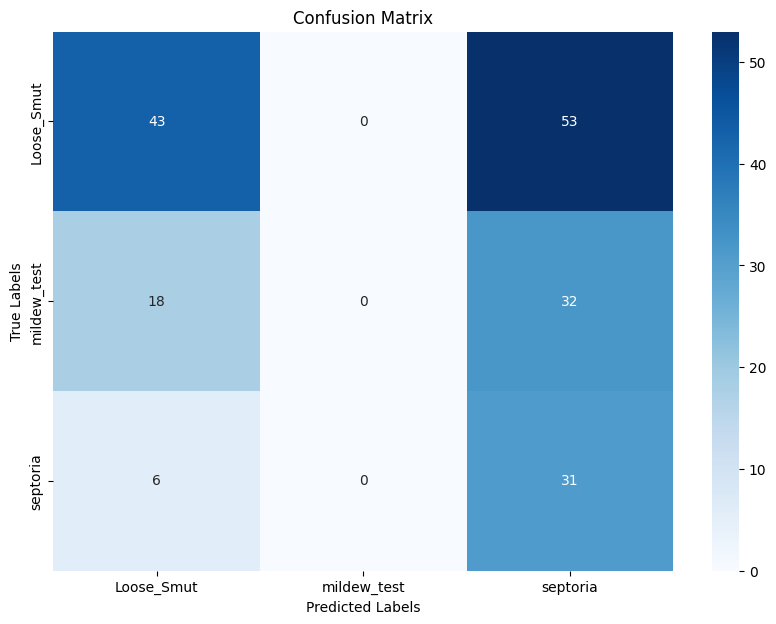

Classification Report:
               precision    recall  f1-score   support

  Loose_Smut       0.64      0.45      0.53        96
 mildew_test       0.00      0.00      0.00        50
    septoria       0.27      0.84      0.41        37

    accuracy                           0.40       183
   macro avg       0.30      0.43      0.31       183
weighted avg       0.39      0.40      0.36       183



C:\Users\DELL\Desktop\PFETesting\paper1\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DELL\Desktop\PFETesting\paper1\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DELL\Desktop\PFETesting\paper1\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

In [24]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Evaluate the model on the test data
y_true = test_gen.classes  # True labels
y_pred = model.predict(test_gen, verbose=1)  # Model predictions
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the class with the highest probability

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Precision, Recall, F1-Score
report = classification_report(y_true, y_pred_classes, target_names=test_gen.class_indices.keys())
print("Classification Report:\n", report)



In [ ]:
# Fine-tune the model
history_fine_tune = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks
)

# Save the final model
model.save('wheat_disease_classifier.h5')